# Disparity Calculation Using PiML and SolasAI

## Introduction



## Import Libraries and Data

Here, we are using the adjusted Friedman #1 Dataset that is created via the script in `/examples/data/`

In [1]:
import pandas as pd
import numpy as np
import plotly.io as pio
import solas_disparity as sd
from sklearn import metrics
from scipy import stats
import statsmodels.api as sm
from piml import Experiment
from piml.models import ExplainableBoostingClassifier


pio.renderers.default = "svg"
pd.set_option('display.max_columns', 1000)
np.random.seed(161803)

# For the notebook, I didn't want the plots to take up too much room, but also didn't want to delete the code that creates them.  Change this to `True` to get PiML's extended output.
show_piml_results = False

In [2]:
df = pd.read_csv('data/segmented_friedman_1.csv.gz', index_col=0)

We rename the protected/reference columns to be common values (Minority / Majority and Age>=62 / Age<62).  This is just to make the results shown in a way that is likely to be familiar to readers.

In [3]:
df.rename(
    columns={
        'protected_1': 'Minority',
        'reference_1': 'Majority',
        'protected_2': 'Age >= 62',
        'reference_2': 'Age < 62',
    },
    inplace=True,
)

protected_groups = ['Minority', 'Age >= 62']
reference_groups = ['Majority', 'Age < 62']
group_categories = ['Race', 'Age']

df.sample(n=5)

,Segment,x1,x2,x3,x4,x5,y,noise,bad,Minority,Majority,Age >= 62,Age < 62,BLUE Linear Estimate of Y,Best Logistic Estimate of BAD
54848,Segment 15,0.152803,0.325204,0.054422,1.200922,-1.199056,-1.979842,-2.560992,0,0.034165,0.965835,0,1,0.542517,0.058137
53189,Segment 14,0.276718,-0.256765,-0.396483,-1.163135,0.258974,-0.613252,-0.833580,0,0.121801,0.878199,0,1,0.185917,0.100152
16320,Segment 6,1.160212,0.882936,0.149230,0.135407,-0.970423,1.489340,1.574834,0,0.697511,0.302489,0,1,-0.085023,0.060697
816,Segment 4,0.576667,0.427731,-1.746224,-1.137797,0.664875,1.327499,-3.627437,0,0.304207,0.695793,0,1,5.078846,0.886537
15022,Segment 6,-0.854609,2.036090,-0.518368,-1.833483,0.521418,1.393193,0.838377,0,0.127386,0.872614,1,0,0.557428,0.118042


et Features, Labels, and a helper dict that holds information and allows the user to easily access the protected and reference group information.

In [4]:
features = ['x1', 'x2', 'x3', 'x4', 'x5', 'Segment']
label = 'bad'

common_disp_info = dict(
    protected_groups=protected_groups,
    reference_groups=reference_groups,
    group_categories=group_categories,
)

## Build and Explain a Model Using PiML

In [5]:
exp = Experiment()
exp.data_loader(df)

,Segment,x1,x2,x3,x4,x5,y,noise,bad,Minority,Majority,Age >= 62,Age < 62,BLUE Linear Estimate of Y,Best Logistic Estimate of BAD
0,Segment 1,-2.697781,-0.642254,0.370297,0.748018,-1.424125,-1.085025,-0.785855,0.0,0.178168,0.821832,1.0,0.0,-0.331529,0.066508
1,Segment 1,1.256522,-1.501616,0.662731,0.178733,-0.132569,0.67651,0.421849,0.0,0.062355,0.937645,0.0,1.0,0.257137,0.11331
2,Segment 1,-0.064053,-0.617098,-1.289419,-0.901302,-0.08264,1.7669,-0.975268,0.0,0.166614,0.833386,1.0,0.0,2.834243,0.640497
3,Segment 1,-0.749886,1.506928,-0.841099,-0.220455,-0.809758,0.216603,-1.446028,0.0,0.114021,0.885979,0.0,1.0,1.713377,0.364506
4,Segment 1,1.695371,-0.526214,-0.016714,1.251901,-0.468502,4.418227,3.781825,1.0,0.033783,0.966217,1.0,0.0,0.609743,0.152934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63235,Segment 15,0.865633,0.244643,1.629236,-0.410947,0.970538,0.70914,-0.860192,0.0,0.039287,0.960713,1.0,0.0,1.556579,0.163854
63236,Segment 15,-1.273168,0.628253,0.867698,0.372415,1.096055,1.256282,0.973674,0.0,0.223615,0.776385,0.0,1.0,0.294422,0.05366
63237,Segment 15,0.997929,0.658184,-0.618099,-0.600917,-0.528071,-0.022656,-1.237266,0.0,0.013925,0.986075,1.0,0.0,1.173896,0.103913
63238,Segment 15,1.349351,0.576261,-0.295542,0.871115,-3.244451,0.467361,-0.106663,0.0,0.28685,0.71315,0.0,1.0,0.502698,0.046988


In [6]:
exp.data_summary(
    feature_exclude=[x for x in df if x not in features + [label]],
    feature_type={key: 'numerical' if key != 'Segment' else 'categorical' for key in features}
)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='Data Shape:(63240, 15)')

In [7]:
exp.data_prepare(
    target=label,
    task_type='Classification',
    test_ratio=0.2,
    random_state=31415,
    with_display=True,
)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,0,1
0,Excluded columns,"[y, noise, Minority, Majority, Age >= 62, Age < 62, BLUE Linear Estimate of Y, Best Logistic Estimate of BAD]"
1,Target colunm,bad
2,Sample weight,None
3,Task type,Classification
4,Test ratio,0.2
5,Random state,31415


In [8]:
if show_piml_results:
    exp.eda(
        show='all',
        uni_feature='Segment',
        bi_features=['x1', 'x2'],
        multi_type='correlation_heatmap',
    )

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [9]:
ebm = ExplainableBoostingClassifier()
exp.model_train(model=ebm, name='EBM')
exp.model_diagnose(model="EBM", show='accuracy_result')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value="<p class='notification info'>Register EBM Done</p>")

,,ACC,AUC,Recall,Precision,F1
0,Train,0.853119,0.855283,0.492832,0.785547,0.605678
1,Test,0.847486,0.846054,0.479294,0.781406,0.594151
2,Gap,-0.005633,-0.009228,-0.013539,-0.004141,-0.011527


In [10]:
if show_piml_results:
    exp.model_explain(
        model='EBM',
        show='global_shap_summary',
        sample_size=500,
    )
    exp.model_interpret(model='EBM', show='global_fi')
    exp.model_interpret(model='EBM', show='global_effect_plot', bi_features=['x1', 'x2'])
    for f_i in features:
        exp.model_interpret(model='EBM', show='global_effect_plot', uni_feature=f_i)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

PiML Uses the random seed for train_test_split sent into `piml.Experiment().data_prepare()`, so we can get the same train/test split using the following code (I couldn't figure out how to do this via PiML directly).  

Note that at SolasAI, we use the train/validation/test nomenclature but PiML uses train/test.  Clearly we are correct.  :-)

In [11]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(df, test_size=0.2, random_state=31415)
train = train.copy()
valid = valid.copy()

# Double-Check that the random_state assumption is correct.
check_same_split = pd.DataFrame(data=exp.get_raw_data().train_x, columns=exp.get_feature_names())
assert np.all(np.abs(train[['x1', 'x2', 'x3', 'x4', 'x5']].values - check_same_split[['x1', 'x2', 'x3', 'x4', 'x5']].values) == 0), "PiML and train_test_split() not producing the same train/test sets"
del check_same_split

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Calculate predicted probabilities from the EBM for the training / validation splits.

In [12]:
train['EBM Prediction'] = exp.get_model(model='EBM').predict_proba(exp.get_raw_data().train_x)[:, 1]
valid['EBM Prediction'] = exp.get_model(model='EBM').predict_proba(exp.get_raw_data().test_x)[:, 1]

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

We know the functional form that the data takes: it is the Friedman #1 with segmentation and custom coefficients.  Given that we know this information, when we created the dataset, we were able to create the "best possible" predictions using a logit and the features specified 
exactly as they entered the data generating process.  In order to test whether the EBM does a decent job finding the data's functional form, we compare the predictions from the PiML EBM to the "best possible" predictions.  We also calculate train/validation KS and AUC values for the EBM model itself.

In [13]:
model_summary = pd.DataFrame(
    columns=['Best Possible Model', 'EBM Train', 'EBM Validation', 'EBM Percent Change', 'Best-to-EBM Validation Percent Change'],
    index=['KS', 'AUC'],
)

model_summary.at['AUC', 'Best Possible Model'] = metrics.roc_auc_score(y_score=df['Best Logistic Estimate of BAD'], y_true=df[label])
model_summary.at['KS', 'Best Possible Model'] = stats.ks_2samp(df.loc[df[label] == 1, 'Best Logistic Estimate of BAD'], df.loc[df[label] == 0, 'Best Logistic Estimate of BAD'])[0]


model_summary.at['AUC', 'EBM Train'] = metrics.roc_auc_score(y_score=train['EBM Prediction'], y_true=train[label])
model_summary.at['AUC', 'EBM Validation'] = metrics.roc_auc_score(y_score=valid['EBM Prediction'], y_true=valid[label])
model_summary.at['KS', 'EBM Train'] = stats.ks_2samp(train.loc[train[label] == 1, 'EBM Prediction'], train.loc[train[label] == 0, 'EBM Prediction'])[0]
model_summary.at['KS', 'EBM Validation'] = stats.ks_2samp(valid.loc[valid[label] == 1, 'EBM Prediction'], valid.loc[valid[label] == 0, 'EBM Prediction'])[0]
model_summary['EBM Percent Change'] = model_summary['EBM Validation'] / model_summary['EBM Train'] - 1
model_summary['Best-to-EBM Validation Percent Change'] = model_summary['EBM Validation'] / model_summary['Best Possible Model'] - 1
model_summary

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,Best Possible Model,EBM Train,EBM Validation,EBM Percent Change,Best-to-EBM Validation Percent Change
KS,0.547956,0.549402,0.531407,-0.032753,-0.0302
AUC,0.855234,0.855283,0.846054,-0.01079,-0.010733


Below, we perform another comparison of the best possible model predictions to the EBM logit.  Here, the OLS coefficients would ideally be beta0 = 0 and beta1 = 1 with an r^2 = 1.  Obviously, it is unlikely that we will get exactly that.  

In [14]:
if show_piml_results:
    valid['intercept'] = 1
    ebm_pred_compare = sm.OLS(endog=valid['EBM Prediction'], exog=valid[['intercept', 'Best Logistic Estimate of BAD']]).fit()
    valid.drop(columns=['intercept'], inplace=True)

    display(ebm_pred_compare.summary())
    valid.plot.scatter(x='Best Logistic Estimate of BAD', y='EBM Prediction')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## Disparity Analysis Using SolasAI

Here, we begin the analysis of the PiML EBM model's predictions assuming that they are used to generate some rankable outcome for consumers.  

### Outcomes Analyzed

Analyses are performed on three `outcomes` generated using the model predictions.  These are:
1. The model's output itself, in probability (`valid['EBM Prediction']`).
2. A binary "Offer" or "No Offer" outcome based on a single threshold cutoff (`valid['Offer']`).
3. Using two cutoff values, we create a waterfall of offers, where the worst scoring group gets no offer, the middle scoring group gets a "good" offer, and the best scoring consumers get the "best" offer (`valid['Tiered Offer']`).

Note, in this simulated data a lower model score is considered a more favorable result for the consumer.  A real-world exmaple of this is credit default models, where the lower the score, the lower the probability of default.  
A lower probability of default is more likely to get an offer or more likely to get a better offer.  Thus, a low score is a favorable outcome from the perspective of the person being scored.

### Disparity Tests Performed


We perform the following tests:
1. `Standardized Mean Difference (SMD)` in the model predictions
2. `Adverse Impact Ratio (AIR) by Quantile` of model predictions.  Decile cutoffs were used for the quantiles.
3. Using the single "Offer" calculated, a standard `AIR` is calculated.
4. Using the single "Offer" calculated, a standard `Odds Ratio (OR)` is calculated.
5. Using the single "Offer" calculated, we create a `Segmented AIR`.  This calculates AIRs for indvidual "segments" of the data and then calculates aggregated AIRs and CMH statistical tests.
6. Using the tiered set of offers, we run a `Categorical AIR`, which calculates disparity comparing: 
    - best vs (good + no offer), and 
    - (best + good) v. no offer.

#### Calculate Offers

This code calculates the single and tiered offers for the EBM model.

In [15]:
single_decision_threshold = 0.15
good_offer_threshold = 0.20
best_offer_threshold = 0.05

valid['Offer'] = (valid['EBM Prediction'] <= single_decision_threshold).astype(int)

valid['Tiered Offer'] = np.where(
    valid['EBM Prediction'] <= best_offer_threshold, 
    'Best Offer', 
    np.where(
        valid['EBM Prediction'] <= good_offer_threshold, 
        'Good Offer', 
        'No Offer'
    )
)
display(valid['Offer'].value_counts(dropna=False, normalize=True))
display(valid['Tiered Offer'].value_counts(dropna=False, normalize=True))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

1    0.577404
0    0.422596
Name: Offer, dtype: float64

Good Offer    0.491461
No Offer      0.331436
Best Offer    0.177103
Name: Tiered Offer, dtype: float64

#### _Standardized Mean Difference (SMD) of Model Predictions_

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## Disparity Calculation: SMD

┌──────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────┐
│ Protected Groups                                         │ Minority, Age >= 62                                  │
│ Reference Groups                                         │ Majority, Age < 62                                   │
│ Group Categories                                         │ Race, Age                                            │
│ SMD Threshold                                            │ 30.0                                                 │
│ Affected Groups                                          │ Minority                                             │
│ Affected Reference                                       │ Majority                                             │
│ Affected Categories                                      │ Race                                                 │
└──────────────────────────────────────────────────────────┴──────────────────────────────────────────────────────┘

\* Percent Missing: Age: 0.00%, Race: 0.00%

## SMD Summary Table

Group Category,Group,Reference Group,Observations,Percent Missing,Total,Average Label,Average Outcome,Standard Deviation of Outcomes,SMD,P-Values,Practically Significant
Race,Minority,Majority,"12,648",0.00%,"3,429.8",0.37,0.31,0.25,43.050,0.000,Yes
Race,Majority,,"12,648",0.00%,"9,218.2",0.18,0.20,0.25,,,
Age,Age >= 62,Age < 62,"12,648",0.00%,"6,392.0",0.23,0.23,0.25,0.798,0.654,No
Age,Age < 62,,"12,648",0.00%,"6,256.0",0.23,0.23,0.25,,,


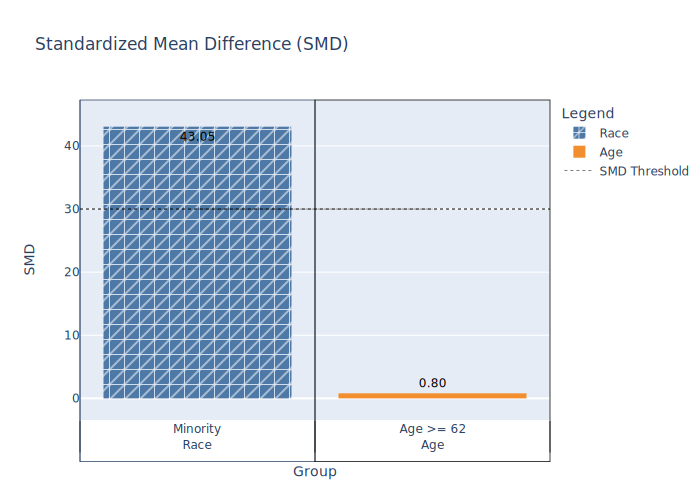

In [16]:
smd = sd.standardized_mean_difference(
    group_data=valid,
    **common_disp_info,
    outcome=valid['EBM Prediction'],
    smd_threshold=30,
    label=valid[label], 
    lower_score_favorable=True,
)
smd
# Note to SolasAI team: SMD does not have the percent_difference_threshold option but it should.

#### _Adverse Impact Ratio (AIR) by Decile of Model Predictions_

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## Disparity Calculation: AIR by Quantile

┌──────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────┐
│ Protected Groups                                         │ Minority, Age >= 62                                  │
│ Reference Groups                                         │ Majority, Age < 62                                   │
│ Group Categories                                         │ Race, Age                                            │
│ AIR Threshold                                            │ 0.9                                                  │
│ % Diff Threshold                                         │ 0.0                                                  │
│ Affected Groups                                          │ Minority                                             │
│ Affected Reference                                       │ Majority                                             │
│ Affected Categories                                      │ Race                                                 │
└──────────────────────────────────────────────────────────┴──────────────────────────────────────────────────────┘

## AIR by Quantile Summary Table

,Group Category,Group,Reference Group,Quantile,Quantile Cutoff,Observations,Percent Missing,Total,Label Favorable,Percent Label Favorable,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant
0,Race,Minority,Majority,0.1,0.036182,12648,0.0,3429.833258,2158.745756,0.629403,230.949368,0.067335,0.044840,0.600270,1.013970e-13,Yes
1,Race,Majority,,0.1,0.036182,12648,0.0,9218.166742,7543.254244,0.818303,1034.050632,0.112175,NaN,NaN,NaN,
2,Age,Age >= 62,Age < 62,0.1,0.036182,12648,0.0,6392.000000,4897.000000,0.766114,635.000000,0.099343,0.001360,0.986491,8.217307e-01,No
3,Age,Age < 62,,0.1,0.036182,12648,0.0,6256.000000,4805.000000,0.768063,630.000000,0.100703,NaN,NaN,NaN,
4,Race,Minority,Majority,0.2,0.054398,12648,0.0,3429.833258,2158.745756,0.629403,506.637555,0.147715,0.071782,0.672969,3.659227e-19,Yes
5,Race,Majority,,0.2,0.054398,12648,0.0,9218.166742,7543.254244,0.818303,2023.362445,0.219497,NaN,NaN,NaN,
6,Age,Age >= 62,Age < 62,0.2,0.054398,12648,0.0,6392.000000,4897.000000,0.766114,1274.000000,0.199312,0.001456,0.992750,8.552869e-01,No
7,Age,Age < 62,,0.2,0.054398,12648,0.0,6256.000000,4805.000000,0.768063,1256.000000,0.200767,NaN,NaN,NaN,
8,Race,Minority,Majority,0.3,0.073084,12648,0.0,3429.833258,2158.745756,0.629403,774.671140,0.225863,0.101787,0.689342,1.517330e-28,Yes
9,Race,Majority,,0.3,0.073084,12648,0.0,9218.166742,7543.254244,0.818303,3020.328860,0.327650,NaN,NaN,NaN,


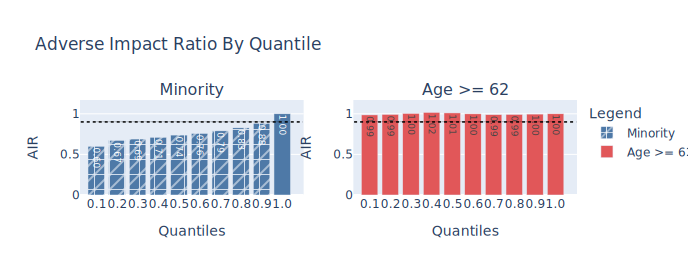

In [17]:
air_by_quantile = sd.adverse_impact_ratio_by_quantile(
    group_data=valid,
    **common_disp_info,
    outcome=valid['EBM Prediction'],
    air_threshold=0.9,
    percent_difference_threshold=0.0,
    label=valid[label],
    lower_score_favorable=True,
    quantiles=[x / 100 for x in range(10, 101, 10)]
)
air_by_quantile
# Note to SolasAI team: AIR by Quantile summary table should be sorted by group_category then quantile.  Also, the summary table is not formatted.

#### _Adverse Impact Ratio (AIR) Assuming a Single Offer_

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## Disparity Calculation: Adverse Impact Ratio

┌──────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────┐
│ Protected Groups                                         │ Minority, Age >= 62                                  │
│ Reference Groups                                         │ Majority, Age < 62                                   │
│ Group Categories                                         │ Race, Age                                            │
│ AIR Threshold                                            │ 0.8                                                  │
│ % Diff Threshold                                         │ 0.0                                                  │
│ Affected Groups                                          │ Minority                                             │
│ Affected Reference                                       │ Majority                                             │
│ Affected Categories                                      │ Race                                                 │
└──────────────────────────────────────────────────────────┴──────────────────────────────────────────────────────┘

\* Percent Missing: Age: 0.00%, Race: 0.00%

## Adverse Impact Ratio Summary Table

Group Category,Group,Reference Group,Observations,Percent Missing,Total,Label Favorable,Percent Label Favorable,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant
Race,Minority,Majority,"12,648",0.00%,"3,429.8","1,271.1",37.06%,"1,597.3",46.57%,15.32%,0.752,0.000,Yes
Race,Majority,,"12,648",0.00%,"9,218.2","1,674.9",18.17%,"5,705.7",61.90%,,,,
Age,Age >= 62,Age < 62,"12,648",0.00%,"6,392.0","1,495.0",23.39%,"3,694.0",57.79%,-0.10%,1.002,0.922,No
Age,Age < 62,,"12,648",0.00%,"6,256.0","1,451.0",23.19%,"3,609.0",57.69%,,,,


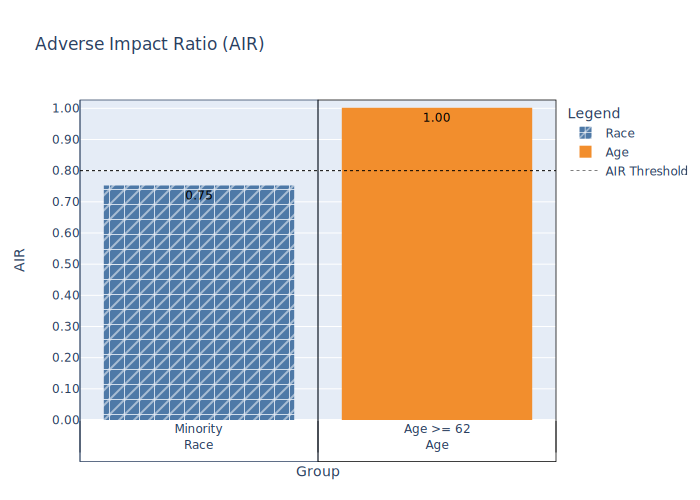

In [18]:
air = sd.adverse_impact_ratio(
    group_data=valid,
    **common_disp_info,
    outcome=valid['Offer'],
    air_threshold=0.8,
    percent_difference_threshold=0.0,
    label=valid[label],
)
air

#### _Segmented Adverse Impact Ratio (AIR) Assuming a Single Offer_

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## Disparity Calculation: Segmented AIR

┌──────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────┐
│ Protected Groups     │ Minority, Age >= 62                                                                      │
│ Reference Groups     │ Majority, Age < 62                                                                       │
│ Group Categories     │ Race, Age                                                                                │
│ AIR Threshold        │ 0.8                                                                                      │
│ % Diff Threshold     │ 0.0                                                                                      │
│ FDR Threshold        │ 0.2                                                                                      │
│ Segments             │ ['Segment 13', 'Segment 11', 'Segment 15', 'Segment 6', 'Segment 5', 'Segment 12',       │
│                      │ 'Segment 14', 'Segment 10', 'Segment 3', 'Segment 4', 'Segment 9', 'Segment 7', 'Segment │
│                      │ 8', 'Segment 2', 'Segment 1']                                                            │
│ Affected Groups      │ Minority                                                                                 │
│ Affected Reference   │ Majority                                                                                 │
│ Affected Categories  │ Race                                                                                     │
└──────────────────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

## Segmented AIR Summary Table

,Group Category,Group,Reference Group,Segment,Observations,Percent Missing,Total,Label Favorable,Percent Label Favorable,Favorable,Percent Favorable,AIR,P-Values,Benjamani-Hochberg Critical Value,Practically Significant
0,Race,Minority,Majority,Segment 13,2978,0.0,834.433948,375.000846,0.449407,275.060839,0.329638,0.692108,5.687938e-13,NaN,Yes
1,Race,Majority,,Segment 13,2978,0.0,2143.566052,515.999154,0.240720,1020.939161,0.476281,NaN,NaN,NaN,
2,Age,Age >= 62,Age < 62,Segment 13,2978,0.0,1521.000000,462.000000,0.303748,659.000000,0.433268,0.991006,8.576340e-01,NaN,No
3,Age,Age < 62,,Segment 13,2978,0.0,1457.000000,429.000000,0.294441,637.000000,0.437200,NaN,NaN,NaN,
4,Race,Minority,Majority,Segment 11,1050,0.0,302.782550,132.490819,0.437577,135.846039,0.448659,0.775755,1.754524e-04,NaN,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,Age,Age < 62,,CMH Test,12648,0.0,6256.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
64,Race,Minority,Majority,Breslow-Day Test,12648,0.0,3429.833258,NaN,NaN,NaN,NaN,0.754766,8.871052e-01,NaN,
65,Race,Majority,,Breslow-Day Test,12648,0.0,9218.166742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
66,Age,Age >= 62,Age < 62,Breslow-Day Test,12648,0.0,6392.000000,NaN,NaN,NaN,NaN,1.001971,8.460088e-01,NaN,


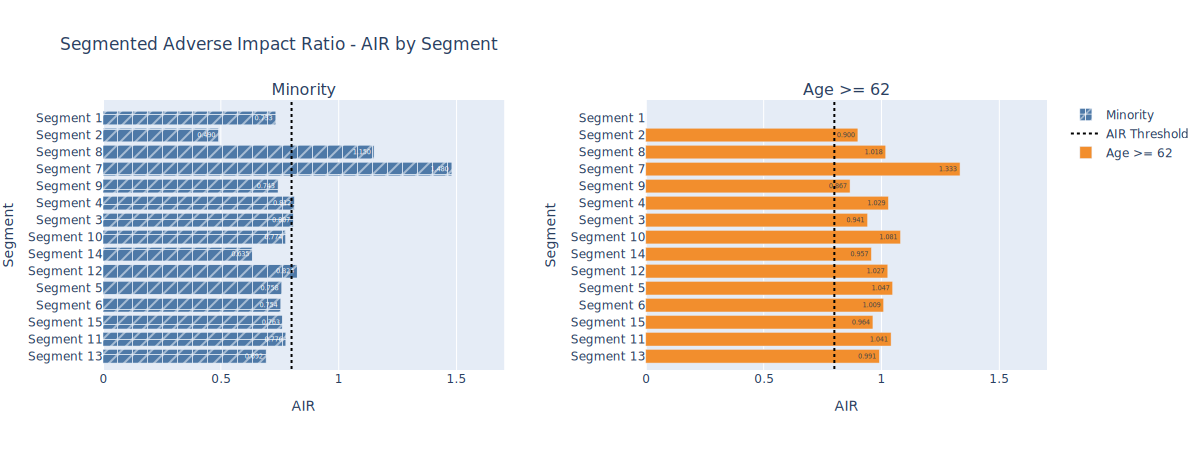

In [19]:
said = sd.segmented_adverse_impact_ratio(
    group_data=valid,
    **common_disp_info,
    outcome=valid['Offer'],
    air_threshold=0.8,
    percent_difference_threshold=0.0,
    label=valid[label],
    segment=valid['Segment'],
    fdr_threshold=0.20,
)
said

#### _Odds Ratio (OR) Assuming Single Offer_

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## Disparity Calculation: Odds Ratio

┌──────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────┐
│ Protected Groups                                         │ Minority, Age >= 62                                  │
│ Reference Groups                                         │ Majority, Age < 62                                   │
│ Group Categories                                         │ Race, Age                                            │
│ Odds Ratio Threshold                                     │ 0.9                                                  │
│ % Diff Threshold                                         │ 0.0                                                  │
│ Affected Groups                                          │ Minority                                             │
│ Affected Reference                                       │ Majority                                             │
│ Affected Categories                                      │ Race                                                 │
└──────────────────────────────────────────────────────────┴──────────────────────────────────────────────────────┘

\* Percent Missing: Age: 0.00%, Race: 0.00%

## Odds Ratio Summary Table

Group Category,Group,Reference Group,Observations,Percent Missing,Total,Label Favorable,Percent Label Favorable,Label Odds,Favorable,Percent Favorable,Odds,Percent Difference Favorable,Odds Ratio,P-Values,Practically Significant
Race,Minority,Majority,"12,648",0.00%,"3,429.8","1,271.1",37.06%,0.588808,"1,597.3",46.57%,0.871674,15.32%,0.536618,0.000,Yes
Race,Majority,,"12,648",0.00%,"9,218.2","1,674.9",18.17%,0.222041,"5,705.7",61.90%,1.624385,,,,
Age,Age >= 62,Age < 62,"12,648",0.00%,"6,392.0","1,495.0",23.39%,0.305289,"3,694.0",57.79%,1.369162,-0.10%,1.004204,0.922,No
Age,Age < 62,,"12,648",0.00%,"6,256.0","1,451.0",23.19%,0.301977,"3,609.0",57.69%,1.363430,,,,


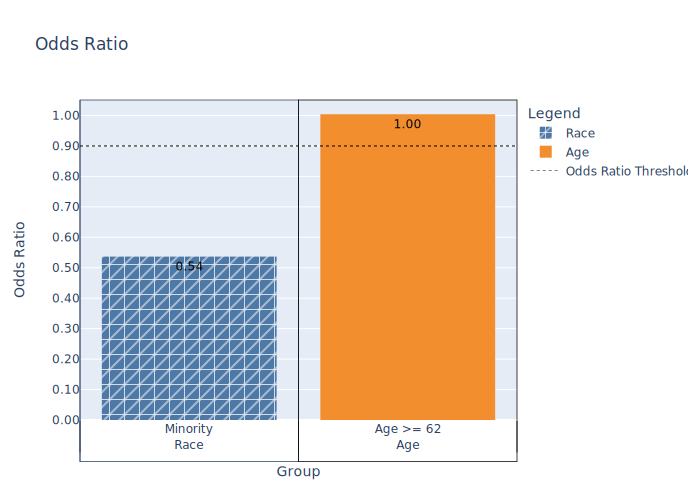

In [20]:
odds_ratio = sd.odds_ratio(
    group_data=valid,
    **common_disp_info,
    outcome=valid['Offer'],
    odds_ratio_threshold=0.9,
    percent_difference_threshold=0.0,
    label=valid[label],
)
odds_ratio

#### _Categorical Adverse Impact Ratio (AIR) Based on a Tiered Set of Offers_

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## Disparity Calculation: Categorical AIR

┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Protected Groups                      │ Minority, Age >= 62                                                     │
│ Reference Groups                      │ Majority, Age < 62                                                      │
│ Group Categories                      │ Race, Age                                                               │
│ Categories                            │ ['No Offer', 'Good Offer', 'Best Offer']                                │
│ Affected Groups                       │ Minority                                                                │
│ Affected Reference                    │ Majority                                                                │
│ Affected Categories                   │ Race                                                                    │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

## Categorical AIR Summary Table

,Group Category,Group,Reference Group,Category,Category Ordinality,Observations,Percent Missing,Total,Label Favorable,Percent Label Favorable,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant
0,Race,Minority,Majority,No Offer,0,12648,0.0,3429.833258,3429.833258,1.000000,3429.833258,1.000000,0.000000,1.000000,1.000000e+00,No
1,Race,Majority,,No Offer,0,12648,0.0,9218.166742,9218.166742,1.000000,9218.166742,1.000000,NaN,NaN,NaN,
2,Age,Age >= 62,Age < 62,No Offer,0,12648,0.0,6392.000000,6392.000000,1.000000,6392.000000,1.000000,0.000000,1.000000,1.000000e+00,No
3,Age,Age < 62,,No Offer,0,12648,0.0,6256.000000,6256.000000,1.000000,6256.000000,1.000000,NaN,NaN,NaN,
4,Race,Minority,Majority,Good Offer,1,12648,0.0,3429.833258,1271.087501,0.370597,1899.692924,0.553873,0.157364,0.778746,1.477327e-62,Yes
5,Race,Majority,,Good Offer,1,12648,0.0,9218.166742,1674.912499,0.181697,6556.307076,0.711238,NaN,NaN,NaN,
6,Age,Age >= 62,Age < 62,Good Offer,1,12648,0.0,6392.000000,1495.000000,0.233886,4263.000000,0.666927,0.003309,0.995063,7.066287e-01,No
7,Age,Age < 62,,Good Offer,1,12648,0.0,6256.000000,1451.000000,0.231937,4193.000000,0.670237,NaN,NaN,NaN,
8,Race,Minority,Majority,Best Offer,2,12648,0.0,3429.833258,0.000000,0.000000,445.121741,0.129779,0.064932,0.666523,2.296894e-17,Yes
9,Race,Majority,,Best Offer,2,12648,0.0,9218.166742,0.000000,0.000000,1794.878259,0.194711,NaN,NaN,NaN,


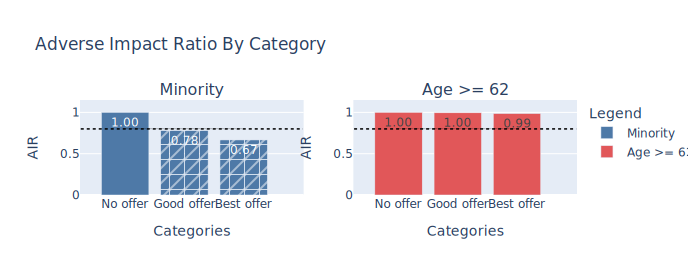

In [21]:
cair = sd.categorical_adverse_impact_ratio(
    group_data=valid,
    **common_disp_info,
    outcome=valid['Tiered Offer'],
    air_threshold=0.8,
    percent_difference_threshold=0.0,
    label=valid[label],
    ordinal_categories=['No Offer', 'Good Offer', 'Best Offer'],
)
cair
# Note to SolasAI team: Categorical AIR Should be sorted so that the AIR for the best offer is the first and the AIR for the worst/no offer is the last.  Ideally, the orinal_categories argument would be left-to-right, best-to-worst.  Plots should also sort this way.